# Importing

 ## Importing the libraries

In [1]:

# Importation des bibliothèques nécessaires
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
import scipy.stats as stats
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV



## Importing dataset 

In [2]:
dataset = pd.read_csv("household_power_consumption.txt", sep=";", low_memory=False)

# Exploring the dataset

## Statistical Analysis

In [3]:
print(f"notre dataset contient {dataset.shape[0]} ligne et {dataset.shape[1]} colonnes")

notre dataset contient 2075259 ligne et 9 colonnes


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


On remarque que on 8 colonne de type objet et 1 de type float 

# Pre-processing the dataset Part 1

# Transformation des données

Pour pouvoir visualiser les colonnes de notres dataset et les analysées , il est crucial de les transformer en float en premier  


In [5]:
dataset.replace('?', np.nan, inplace=True)
# Étape 2 : Création de Datetime
dataset['Datetime'] = pd.to_datetime(dataset['Date'] + ' ' + dataset['Time'], format="%d/%m/%Y %H:%M:%S")
# Étape 3 : Conversion des colonnes numériques
cols_num = [
    'Global_active_power', 'Global_reactive_power', 'Voltage',
    'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]
dataset[cols_num] = dataset[cols_num].astype(float)  # Convertit en float, remplace les erreurs par NaN


### Extraction des variables temporelles

In [6]:
# Étape 5 : Extraction des variables temporelles
dataset['hour'] = dataset['Datetime'].dt.hour
dataset['day_of_week'] = dataset['Datetime'].dt.dayofweek  # 0 = lundi
dataset['month'] = dataset['Datetime'].dt.month
dataset['is_weekend'] = dataset['day_of_week'].isin([5, 6]).astype(int)

# Étape 6 : Transformation cyclique de l'heure
dataset['hour_sin'] = np.sin(2 * np.pi * dataset['hour'] / 24)
dataset['hour_cos'] = np.cos(2 * np.pi * dataset['hour'] / 24)

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 16 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Date                   object        
 1   Time                   object        
 2   Global_active_power    float64       
 3   Global_reactive_power  float64       
 4   Voltage                float64       
 5   Global_intensity       float64       
 6   Sub_metering_1         float64       
 7   Sub_metering_2         float64       
 8   Sub_metering_3         float64       
 9   Datetime               datetime64[ns]
 10  hour                   int32         
 11  day_of_week            int32         
 12  month                  int32         
 13  is_weekend             int32         
 14  hour_sin               float64       
 15  hour_cos               float64       
dtypes: datetime64[ns](1), float64(9), int32(4), object(2)
memory usage: 221.7+ MB


In [8]:
dataset.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,hour,day_of_week,month,is_weekend,hour_sin,hour_cos
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2075259,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00,2008-12-06 07:12:59.999994112,1.150076e+01,2.998909e+00,6.450359e+00,2.853793e-01,-9.965586e-05,1.847142e-05
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,2006-12-16 17:24:00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2007-12-12 00:18:30,6.000000e+00,1.000000e+00,3.000000e+00,0.000000e+00,-7.071068e-01,-7.071068e-01
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2008-12-06 07:13:00,1.200000e+01,3.000000e+00,6.000000e+00,0.000000e+00,0.000000e+00,6.123234e-17
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01,2009-12-01 14:07:30,1.800000e+01,5.000000e+00,9.000000e+00,1.000000e+00,7.071068e-01,7.071068e-01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01,2010-11-26 21:02:00,2.300000e+01,6.000000e+00,1.200000e+01,1.000000e+00,1.000000e+00,1.000000e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00,NaN,6.922227e+00,2.000064e+00,3.415762e+00,4.515950e-01,7.071364e-01,7.070775e-01


In [9]:
print("\nValeurs manquantes par colonne :")
print(dataset.isnull().sum())


Valeurs manquantes par colonne :
Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
Datetime                     0
hour                         0
day_of_week                  0
month                        0
is_weekend                   0
hour_sin                     0
hour_cos                     0
dtype: int64


Nos colonnes de types numériques contient 25979 valeurs manquantes 

In [10]:
duplicates = dataset[dataset.duplicated()]

# Afficher le nombre de lignes dupliquées
print(f"Nombre de lignes dupliquées : {duplicates.shape[0]}")

Nombre de lignes dupliquées : 0


On a pas de valeurs redondantes dans notres dataset 

## Data vizualisation

In [11]:
dataset.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,hour,day_of_week,month,is_weekend,hour_sin,hour_cos
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00,17,5,12,1,-0.965926,-0.258819
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00,17,5,12,1,-0.965926,-0.258819
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00,17,5,12,1,-0.965926,-0.258819
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00,17,5,12,1,-0.965926,-0.258819
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00,17,5,12,1,-0.965926,-0.258819


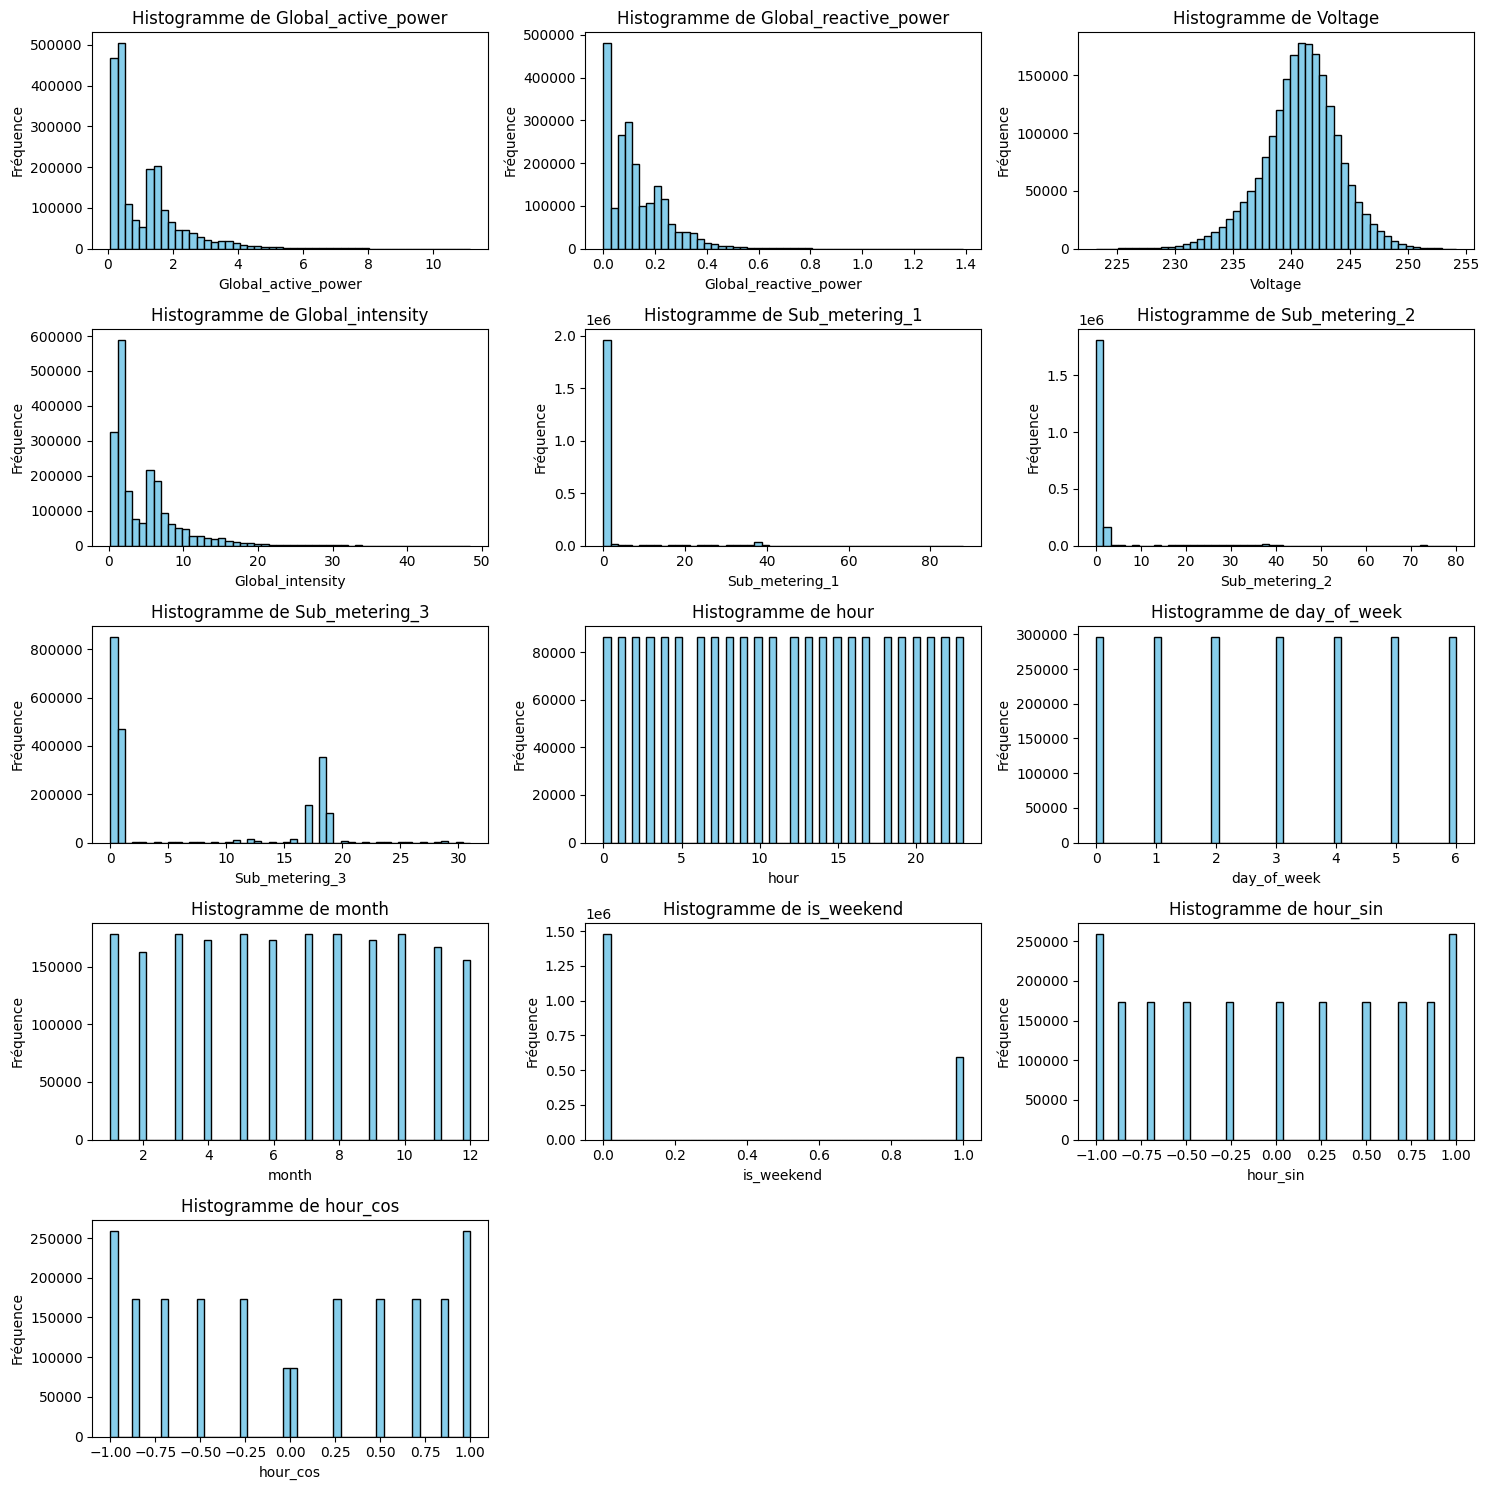

In [12]:
# Liste des colonnes numériques, incluant les nouvelles variables temporelles
cols_num = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
            'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 
            'hour', 'day_of_week', 'month', 'is_weekend', 'hour_sin', 'hour_cos']

# Créer un nombre optimal de sous-figures selon le nombre de colonnes
n_cols = 3  # Nombre de colonnes
n_rows = (len(cols_num) // n_cols) + (1 if len(cols_num) % n_cols != 0 else 0)  # Calculer le nombre de lignes

# Créer les subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
axes = axes.flatten()  # Aplatir les axes pour faciliter l'accès

# Tracer les histogrammes pour chaque variable
for i, col in enumerate(cols_num):
    axes[i].hist(dataset[col], bins=50, color='skyblue', edgecolor='black')
    axes[i].set_title(f"Histogramme de {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Fréquence")

# Supprimer les axes non utilisés si nécessaire
for i in range(len(cols_num), len(axes)):
    axes[i].axis('off')

# Ajuster les espacements entre les subplots
plt.tight_layout()

# Sauvegarder l'image
plt.savefig("Statistiques images/regression/histogrammes_temporals_optimized.png", dpi=70)

# Afficher l'histogramme
plt.show()

#### Distribution asymétrique  pour la plupart des variables :

    
-Les variables Global_active_power, Global_reactive_power, Global_intensity, et les Sub_metering sont fortement asymétriques vers la droite.
-Cela signifie que la majorité des valeurs sont faibles, mais qu’il existe des valeurs plus élevées qui pourraient être considérées comme des outliers.

#### Données de consommation énergétique avec beaucoup de zéros :
-Les variables Sub_metering_1, Sub_metering_2, et Sub_metering_3 ont une grande concentration de valeurs à 0.
- Cela pourrait indiquer des moments où aucun appareil spécifique n’était en fonctionnement.

#### Voltage suit une distribution plus normale :
-Contrairement aux autres, la variable Voltage a une distribution en forme de cloche, suggérant une distribution normale.
- Cela peut être utile pour certains modèles de régression qui supposent une normalité des données.

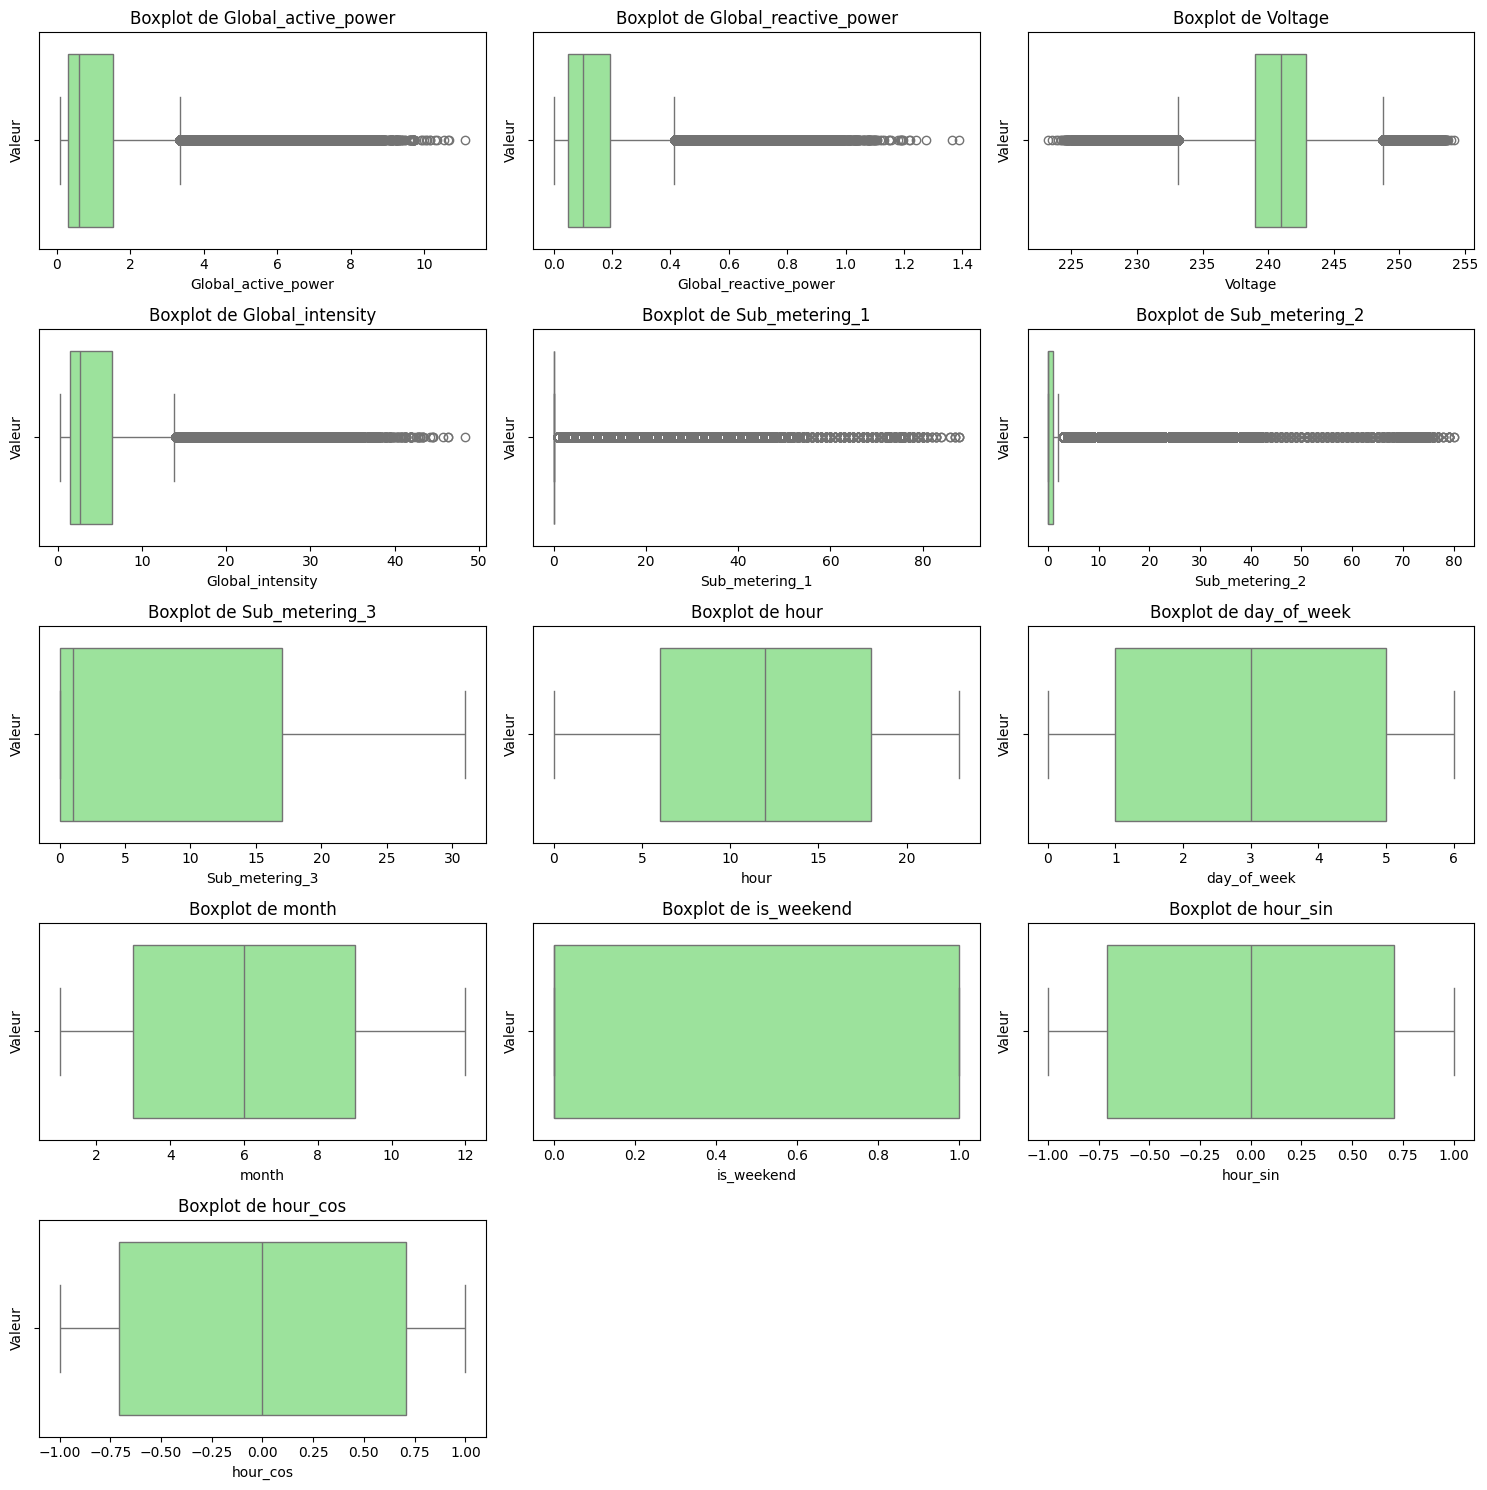

In [13]:
# Créer les subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
axes = axes.flatten()  # Aplatir les axes pour faciliter l'accès

# Tracer les boxplots pour chaque variable
for i, col in enumerate(cols_num):
    sns.boxplot(data=dataset, x=col, ax=axes[i], color='lightgreen')
    axes[i].set_title(f"Boxplot de {col}", fontsize=12)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Valeur")

# Supprimer les axes non utilisés si nécessaire
for i in range(len(cols_num), len(axes)):
    axes[i].axis('off')

# Ajuster les espacements entre les subplots
plt.tight_layout()

# Sauvegarder l'image
plt.savefig("Statistiques images/regression/boxplots_optimized.png", dpi=70)

# Afficher le graphe
plt.show()

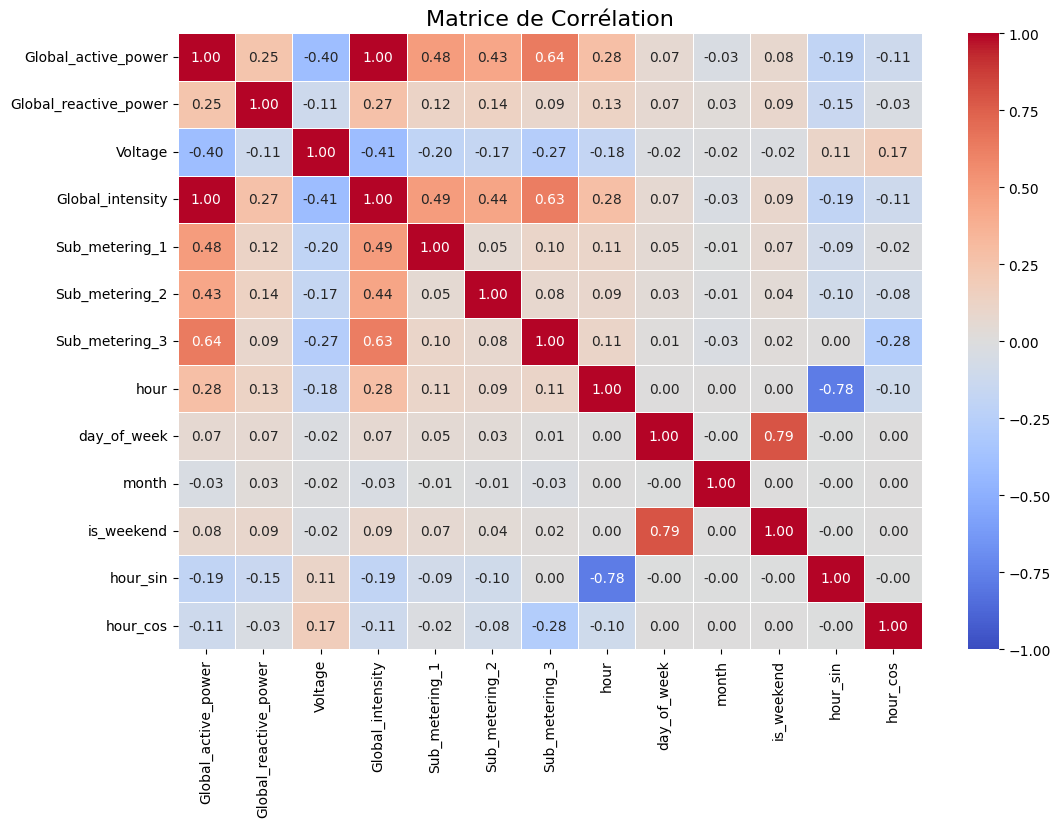

                       Global_active_power  Global_reactive_power   Voltage  \
Global_active_power               1.000000               0.247017 -0.399762   
Global_reactive_power             0.247017               1.000000 -0.112246   
Voltage                          -0.399762              -0.112246  1.000000   
Global_intensity                  0.998889               0.266120 -0.411363   
Sub_metering_1                    0.484401               0.123111 -0.195976   
Sub_metering_2                    0.434569               0.139231 -0.167405   
Sub_metering_3                    0.638555               0.089617 -0.268172   
hour                              0.281602               0.127892 -0.176050   
day_of_week                       0.065813               0.069531 -0.021412   
month                            -0.032654               0.027211 -0.015191   
is_weekend                        0.084633               0.088927 -0.021743   
hour_sin                         -0.188206          

In [14]:

# Calcul de la matrice de corrélation
corr_matrix = dataset[cols_num].corr()

# Créer une figure avec une taille adaptée
plt.figure(figsize=(12, 8))

# Tracer la heatmap de la matrice de corrélation
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)

# Ajouter un titre
plt.title("Matrice de Corrélation", fontsize=16)

# Sauvegarder l'image
plt.savefig("Statistiques images/regression/matrice_correlation_optimized.png", dpi=70)

# Afficher la figure
plt.show()

# Afficher la matrice de corrélation dans la console
print(corr_matrix)

### Observations
 #### Corrélations très fortes :
 -Global_active_power et Global_intensity ont une corrélation extrêmement forte (1).
Cela signifie que plus l'intensité globale augmente, plus la puissance active augmente 

 #### Corrélations moyennes :
- Sub_metering_3 est  corrélé avec Global_active_power (0.64) et Global_intensity (0.63).
- Sub_metering_1 et Sub_metering_2 sont aussi corrélés avec Global_active_power (0.48 et 0.43)
 #### Faibles corrélations avec Global_reactive_power :

  -Global_reactive_power (puissance réactive) a une corrélation assez faible avec Global_active_power (0.25).

 #### Relations négatives avec Voltage :

   - Voltage a une corrélation négative avec Global_active_power (-0.40) et Global_intensity (-0.41).


# Pre-processing the dataset Part 2

## Cleaning the dataset: missing values, duplicates

### Missing Values 

In [15]:
# Vérifier le nombre de valeurs manquantes par colonne
print(dataset.isnull().sum())

Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
Datetime                     0
hour                         0
day_of_week                  0
month                        0
is_weekend                   0
hour_sin                     0
hour_cos                     0
dtype: int64


In [16]:
# Calcul de l'asymétrie (skewness) pour chaque colonne
skew_values = dataset[cols_num].skew()

print("Coefficient d'asymétrie (skewness) des colonnes numériques :")
print(skew_values)

Coefficient d'asymétrie (skewness) des colonnes numériques :
Global_active_power      1.786233
Global_reactive_power    1.261914
Voltage                 -0.326665
Global_intensity         1.849100
Sub_metering_1           5.944541
Sub_metering_2           7.090553
Sub_metering_3           0.724688
hour                    -0.000203
day_of_week              0.001123
month                    0.002624
is_weekend               0.950502
hour_sin                 0.000169
hour_cos                -0.000066
dtype: float64


 -Si |skewness| < 0.5 → Distribution symétrique, on peut utiliser la moyenne
 
 -Si |skewness| > 0.5 → Distribution asymétrique, on préfère la médiane

In [17]:
# Colonnes avec une distribution symétrique → Remplacement par la moyenne
dataset["Voltage"] = dataset["Voltage"].fillna(dataset["Voltage"].mean())

# Colonnes avec une distribution asymétrique → Remplacement par la médiane
cols_median = ["Global_active_power", "Global_reactive_power", "Global_intensity", 
               "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]

dataset[cols_median] = dataset[cols_median].apply(lambda col: col.fillna(col.median()))

In [18]:
# Vérifier le nombre de valeurs manquantes par colonne
print(dataset.isnull().sum())

Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
Datetime                 0
hour                     0
day_of_week              0
month                    0
is_weekend               0
hour_sin                 0
hour_cos                 0
dtype: int64


### Let's check the duplicates

In [19]:
# Compter le nombre de lignes dupliquées
nb_duplicated = dataset.duplicated().sum()
print(f"Nombre de lignes dupliquées : { nb_duplicated}")

Nombre de lignes dupliquées : 0


### Suppression des outliers 

In [20]:
Q1 = dataset[cols_num].quantile(0.25)
Q3 = dataset[cols_num].quantile(0.75)
IQR = Q3 - Q1
dataset_cleaned = dataset[~((dataset[cols_num] < (Q1 - 1.5 * IQR)) | (dataset[cols_num] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [21]:
print(dataset_cleaned.shape[0])


1761136


In [22]:
print(dataset_cleaned.describe())

       Global_active_power  Global_reactive_power       Voltage  \
count         1.761136e+06           1.761136e+06  1.761136e+06   
mean          8.357144e-01           1.107119e-01  2.412135e+02   
min           7.600000e-02           0.000000e+00  2.332600e+02   
25%           2.920000e-01           4.600000e-02  2.395100e+02   
50%           4.520000e-01           9.600000e-02  2.412400e+02   
75%           1.384000e+00           1.760000e-01  2.430300e+02   
max           3.334000e+00           4.080000e-01  2.486200e+02   
std           7.049677e-01           9.462071e-02  2.802934e+00   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
count      1.761136e+06       1761136.0    1.761136e+06    1.761136e+06   
mean       3.537225e+00             0.0    3.377110e-01    5.589229e+00   
min        2.000000e-01             0.0    0.000000e+00    0.000000e+00   
25%        1.200000e+00             0.0    0.000000e+00    0.000000e+00   
50%        2.000000e+

In [23]:
print(dataset_cleaned.columns)

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'Datetime', 'hour', 'day_of_week', 'month',
       'is_weekend', 'hour_sin', 'hour_cos'],
      dtype='object')


# Data Splittage

In [24]:
print(dataset_cleaned.columns[5])
print(dataset_cleaned.columns[2])
x=dataset_cleaned.iloc[:,5].values.reshape(-1, 1) #pour le transofmer en tableau 2D
y=dataset_cleaned.iloc[:,2].values
print(dataset_cleaned.iloc[:,5])

Global_intensity
Global_active_power
16         13.8
18         13.8
25         13.6
26         13.6
27         13.6
           ... 
2075254     4.0
2075255     4.0
2075256     3.8
2075257     3.8
2075258     3.8
Name: Global_intensity, Length: 1761136, dtype: float64


In [25]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=1/3,random_state=0)

### Standarisation

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # fit + transform sur le train
X_test_scaled = scaler.transform(X_test)

# Model Evaluation

In [27]:
def evaluate_regression(y_true, y_pred, model_name="Modèle de Régression"):
    """
    Évalue un modèle de régression avec des métriques et des visualisations.

    Paramètres :
    - y_true : valeurs réelles
    - y_pred : valeurs prédites par le modèle
    - model_name : nom du modèle (optionnel)

    Sauvegarde :
    - MSE, RMSE, MAE, R²
    - Graphique des résidus
    - Comparaison des prédictions aux valeurs réelles
    """
    
    save_path = "Statistiques images/regression/"

    # Calcul des métriques
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Affichage des métriques
    print(f"\nÉvaluation du modèle : {model_name}")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"R²   : {r2:.4f}")

    # Graphique des résidus 
    plt.figure(figsize=(6, 5))
    residuals = y_true - y_pred
    sns.scatterplot(x=y_pred, y=residuals, color="blue", alpha=0.5)
    plt.axhline(y=0, color="red", linestyle="--")
    plt.xlabel("Valeurs prédites")
    plt.ylabel("Résidus")
    plt.title(f"Graphique des Résidus ({model_name})")
    plt.savefig(os.path.join(save_path, f"residus_{model_name}.png"), dpi=130)
    plt.show()  

    #  Graphique comparaison valeurs réelles vs prédites 
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=y_true, y=y_pred, color="blue", alpha=0.5, label="Prédictions")
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color="red", linestyle="--", label="Corrélation parfaite")
    plt.xlabel("Valeurs réelles")
    plt.ylabel("Valeurs prédites")
    plt.legend()
    plt.title(f"Comparaison Prédictions vs Réelles ({model_name})")
    plt.savefig(os.path.join(save_path, f"comparaison_prediction_valeurs_{model_name}.png"), dpi=130)
    plt.show()  # Ferme la figure après l'enregistrement

    return {"Modèle": model_name, "MSE": mse, "RMSE": rmse, "MAE": mae, "R²": r2}

In [28]:
def evaluate_regression_apres_optimisation(y_true, y_pred, model_name="Modèle de Régression"):
    """
    Évalue un modèle de régression avec des métriques et des visualisations.

    Paramètres :
    - y_true : valeurs réelles
    - y_pred : valeurs prédites par le modèle
    - model_name : nom du modèle (optionnel)

    Sauvegarde :
    - MSE, RMSE, MAE, R²
    - Graphique des résidus
    - Comparaison des prédictions aux valeurs réelles
    """
    
    save_path = "Statistiques images/regression/"

    # Calcul des métriques
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Affichage des métriques
    print(f"\nÉvaluation du modèle : {model_name}")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"R²   : {r2:.4f}")

    return {"Modèle": model_name, "MSE": mse, "RMSE": rmse, "MAE": mae, "R²": r2}

# Model Training

## Linear Regression

In [29]:
regressor=LinearRegression()
regressor.fit(X_train,y_train)


LinearRegression()

In [30]:
y_pred_reg=regressor.predict(X_test)

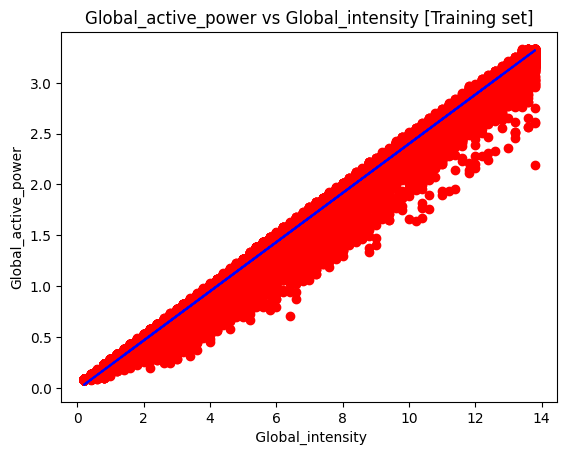

In [31]:
plt.scatter(X_train,y_train,color='red')
plt.plot(X_train,regressor.predict(X_train),color='blue')
plt.title('Global_active_power vs Global_intensity [Training set]')
plt.xlabel(' Global_intensity')
plt.ylabel('Global_active_power')
plt.savefig("Statistiques images/regression/regression_training_set.png", dpi=70)
plt.show()
        

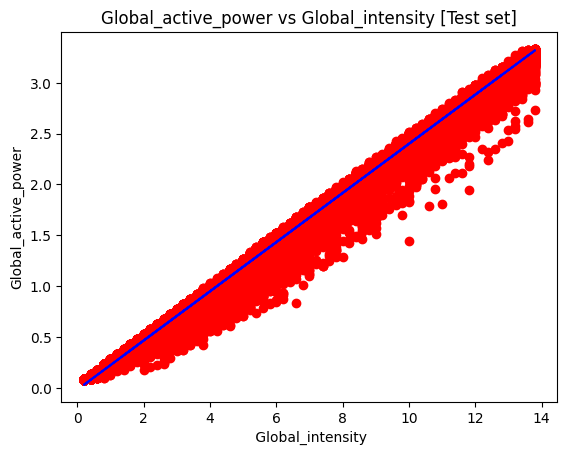

In [32]:
plt.scatter(X_test,y_test,color='red')
plt.plot(X_train,regressor.predict(X_train),color='blue')
plt.title('Global_active_power vs Global_intensity [Test set]')
plt.xlabel(' Global_intensity')
plt.ylabel('Global_active_power')
plt.savefig("Statistiques images/regression/regression test set.png", dpi=70)
plt.show()


Évaluation du modèle : Regression linéaire simple 
MSE  : 0.0016
RMSE : 0.0401
MAE  : 0.0278
R²   : 0.9968


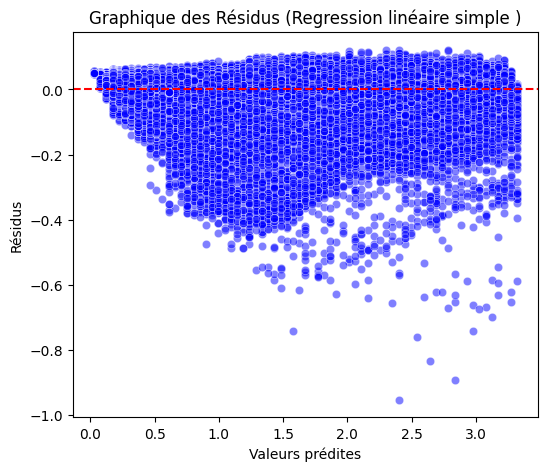

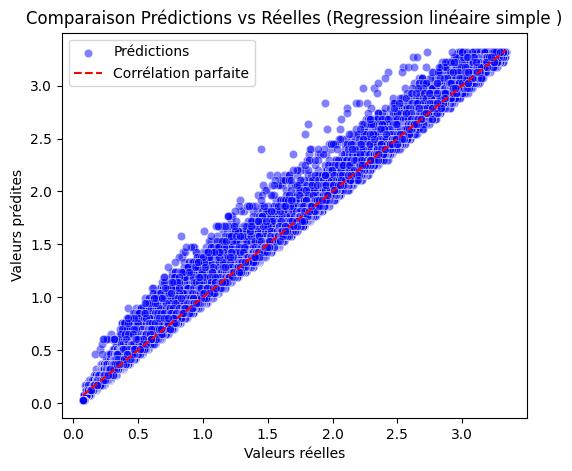

In [33]:
metrics_regression_lineaire= evaluate_regression(y_test, y_pred_reg, model_name="Regression linéaire simple ")

### Validation croisée pour la regression lineaire 

In [34]:
regression_scores = cross_val_score(regressor, x, y, cv=5, scoring='r2')
print("Score moyen :", regression_scores.mean())  # Score final

Score moyen : 0.9967353869129679


## Regression lineaire Simple avec regularisationn

In [35]:
lasso = Lasso(alpha=0.1)  # alpha = paramètre de régularisation (plus il est grand, plus la pénalisation est forte)
lasso.fit(X_train_scaled, y_train)
y_pred_regR = lasso.predict(X_test_scaled)


Évaluation du modèle : Regression linéaire simple avec regularisation 
MSE  : 0.0116
RMSE : 0.1076
MAE  : 0.0928
R²   : 0.9767


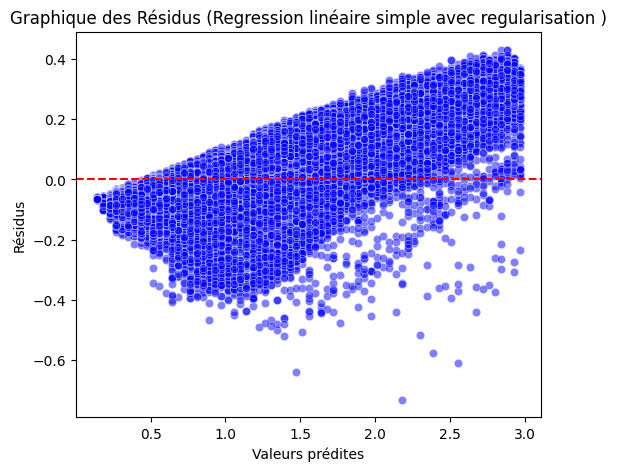

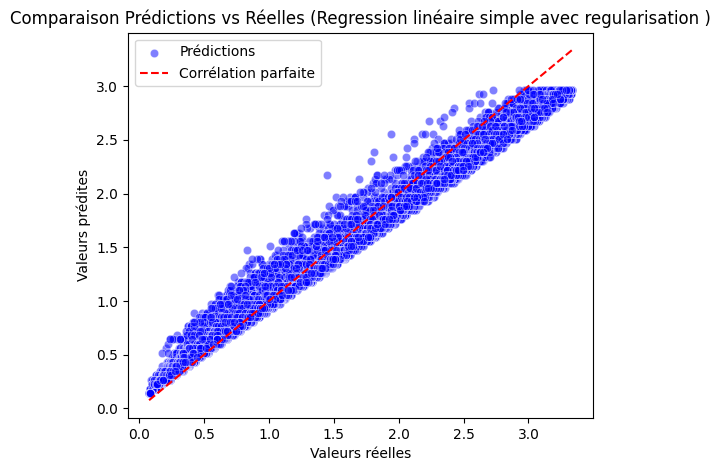

In [36]:
metrics_regression_lineaire= evaluate_regression(y_test, y_pred_regR, model_name="Regression linéaire simple avec regularisation ")

### Validation croisée pour la regression lineaire avec regularisation

In [37]:
regression_with_regularisation_scores = cross_val_score(lasso, x, y, cv=5, scoring='r2')
print("Score moyen :", regression_with_regularisation_scores.mean())

Score moyen : 0.9943191702479928


## Multiple Linear Regression 

In [38]:
features = [
    'Global_reactive_power', 'Voltage', 
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
    'hour_sin', 'hour_cos', 'month', 'is_weekend'
]

X = dataset_cleaned[features]
y = dataset_cleaned['Global_active_power']

In [39]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [40]:
cols_to_scale = [
    'Global_reactive_power', 'Voltage',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]

scaler = StandardScaler()

# Apprentissage du scaler uniquement sur les données d'entraînement
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

In [41]:
ML_regressor = LinearRegression()
ML_regressor.fit(X_train_scaled, y_train)


LinearRegression()

In [42]:

y_pred_RLM = ML_regressor.predict(X_test_scaled)


Évaluation du modèle : Regression linéaire Multipe 
MSE  : 0.1792
RMSE : 0.4234
MAE  : 0.2842
R²   : 0.6394


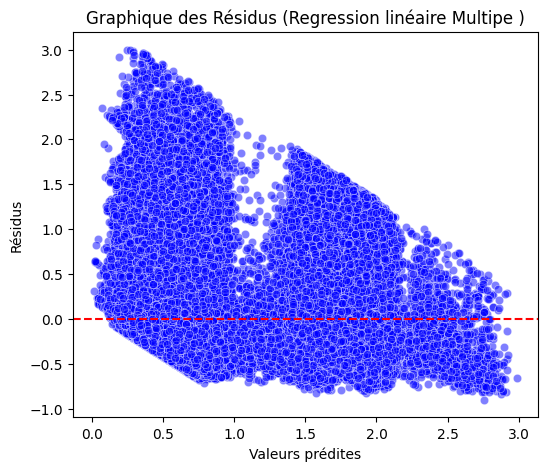

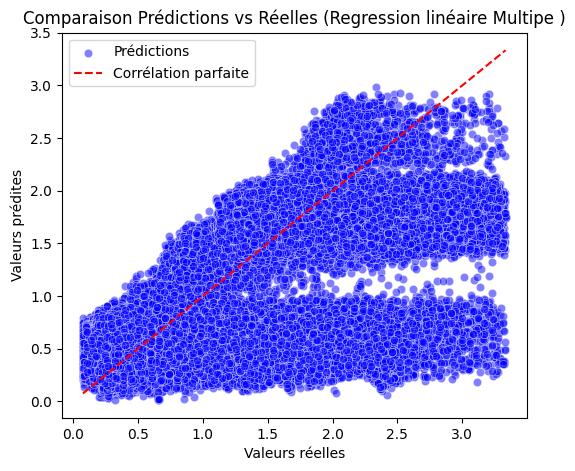

In [43]:
metrics_regression_lineaire= evaluate_regression(y_test, y_pred_RLM, model_name="Regression linéaire Multipe ")

## Multiple Linear Regression avec regularisation

In [44]:
lasso = Lasso(alpha=0.1)  # alpha = paramètre de régularisation (plus il est grand, plus la pénalisation est forte)
lasso.fit(X_train_scaled, y_train)
y_pred_regR = lasso.predict(X_test_scaled)


Évaluation du modèle : Regression linéaire multipe avec regularisation 
MSE  : 0.2118
RMSE : 0.4602
MAE  : 0.3175
R²   : 0.5740


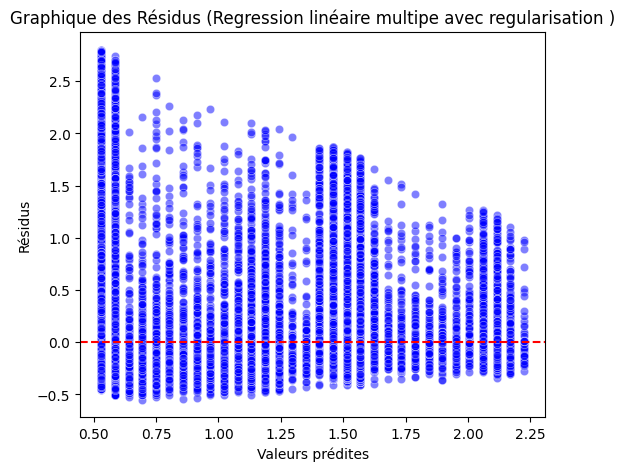

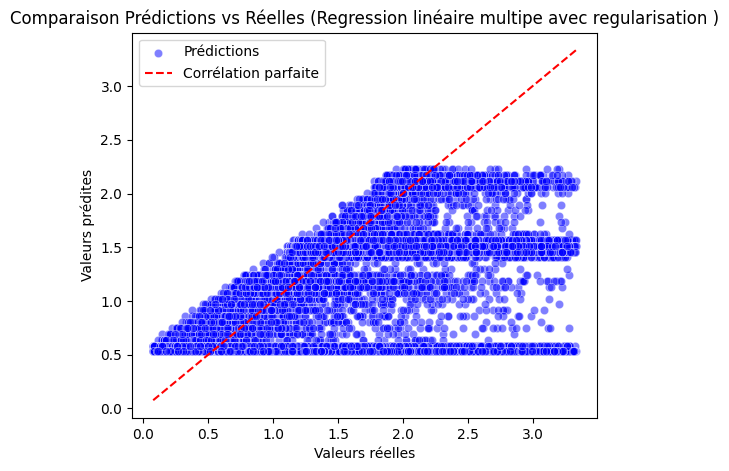

In [45]:
metrics_regression_lineaire= evaluate_regression(y_test, y_pred_regR, model_name="Regression linéaire multipe avec regularisation ")

## DecisionTree Regression 

In [46]:
# Créer le modèle
tree_regressor = DecisionTreeRegressor(max_depth=7, random_state=42)  # Ajuste max_depth si nécessaire

# Entraîner sur les données d'entraînement
tree_regressor.fit(X_train_scaled, y_train)

DecisionTreeRegressor(max_depth=7, random_state=42)

In [47]:

y_pred_DT = tree_regressor.predict(X_test_scaled)


Évaluation du modèle : Decision Tree Regression 
MSE  : 0.1332
RMSE : 0.3649
MAE  : 0.2311
R²   : 0.7321


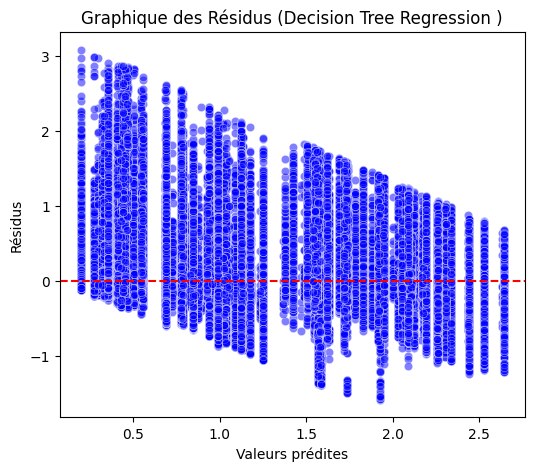

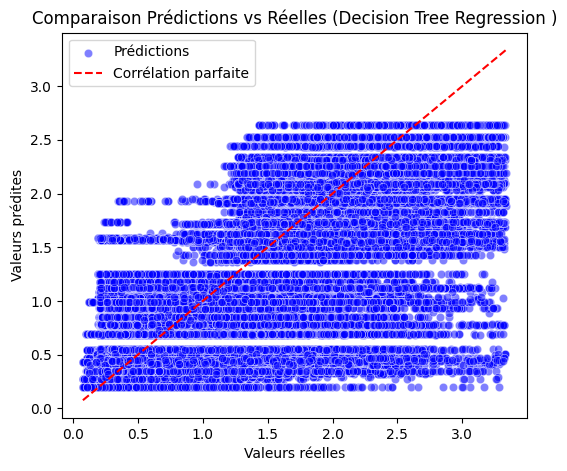

In [48]:
metrics_Decision_Tree_Regression= evaluate_regression(y_test, y_pred_DT, model_name="Decision Tree Regression ")

### Optimisation de decision tree avec RandomizedSearchCV

In [49]:

param_dist_dt = {
    "max_depth": [3, 5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

random_search_dt = RandomizedSearchCV(
    tree_regressor, param_distributions=param_dist_dt, 
    n_iter=10, cv=5, scoring='r2', 
    n_jobs=-1, verbose=2, random_state=42
)

random_search_dt.fit(X_train, y_train)
y_pred_dt = random_search_dt.best_estimator_.predict(X_test)
print("Decision Tree - Meilleurs paramètres :", random_search_dt.best_params_)
print("R² Decision Tree :", r2_score(y_test, y_pred_dt))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Decision Tree - Meilleurs paramètres : {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 20}
R² Decision Tree : 0.8014018101689692


In [50]:
evaluate_regression_apres_optimisation( y_test,y_pred_dt,"Decision Tree")


Évaluation du modèle : Decision Tree
MSE  : 0.0987
RMSE : 0.3142
MAE  : 0.1709
R²   : 0.8014


{'Modèle': 'Decision Tree',
 'MSE': 0.09871967030279236,
 'RMSE': 0.3141968655203173,
 'MAE': 0.1708581268989022,
 'R²': 0.8014018101689692}

## Random Forest Regression 

In [51]:
# Initialiser le modèle Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=42)
#  Entraîner le modèle
rf.fit(X_train, y_train)
#  Faire des prédictions
y_pred_RF = rf.predict(X_test)


Évaluation du modèle : Random Forest Regression 
MSE  : 0.1305
RMSE : 0.3612
MAE  : 0.2294
R²   : 0.7375


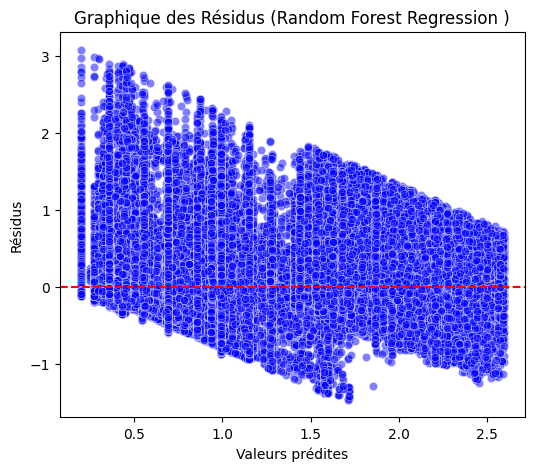

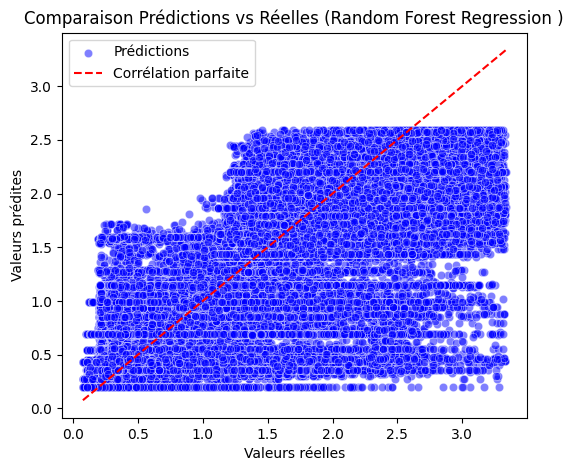

In [52]:
metrics_Random_Forest_Regression= evaluate_regression(y_test, y_pred_RF, model_name="Random Forest Regression ")

### optimisation de random forest avec RandomizedSearchCV

In [53]:

param_dist_rf = {
    "n_estimators": [50, 100, 200, 500],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}

random_search_rf = RandomizedSearchCV(
    rf, param_distributions=param_dist_rf, 
    n_iter=10, cv=5, scoring='r2', 
    n_jobs=-1, verbose=2, random_state=42
)

random_search_rf.fit(X_train, y_train)
y_pred_rf = random_search_rf.best_estimator_.predict(X_test)
print("Random Forest - Meilleurs paramètres :", random_search_rf.best_params_)
print("R² Random Forest :", r2_score(y_test, y_pred_rf))


Fitting 5 folds for each of 10 candidates, totalling 50 fits


D:\S5\S6\PFE\application\env\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
8 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "D:\S5\S6\PFE\application\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\S5\S6\PFE\application\env\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\S5\S6\PFE\application\env\Lib\site-packages\sklearn\ensemble\_forest.py", line 489, in fit
    tre

Random Forest - Meilleurs paramètres : {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': True}
R² Random Forest : 0.8394300594522499


In [54]:
evaluate_regression_apres_optimisation( y_test,y_pred_rf,"Random Forest")


Évaluation du modèle : Random Forest
MSE  : 0.0798
RMSE : 0.2825
MAE  : 0.1555
R²   : 0.8394


{'Modèle': 'Random Forest',
 'MSE': 0.07981649583462659,
 'RMSE': 0.2825181336385801,
 'MAE': 0.1554850533532983,
 'R²': 0.8394300594522499}

## Gradient Boosting Regressor

In [138]:
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

In [139]:
gbr.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [140]:
y_pred_gbr = gbr.predict(X_test)


Évaluation du modèle : Gradient Boosting 
MSE  : 0.1203
RMSE : 0.3469
MAE  : 0.2194
R²   : 0.7580


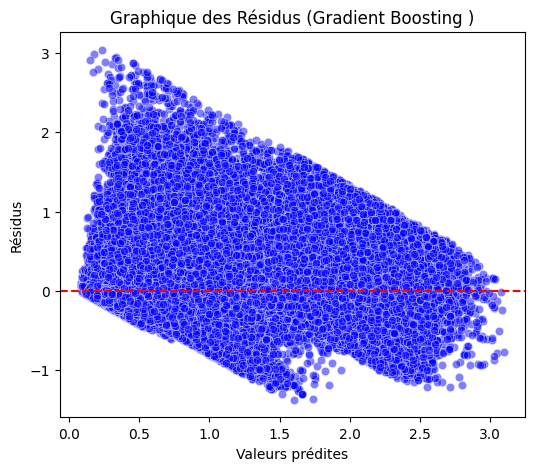

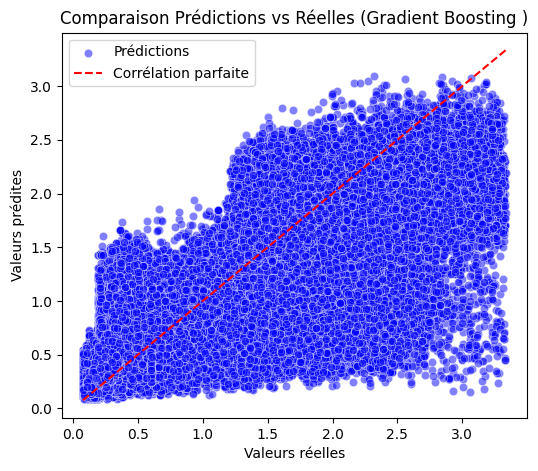

In [141]:
metrics_Gradient_Boosting_Regression= evaluate_regression(y_test, y_pred_gbr, model_name="Gradient Boosting ")

### Optimisation de Gradient Boosting avec RandomizedSearchCV

In [142]:


param_dist_gb = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

random_search_gb = RandomizedSearchCV(
    gbr, param_distributions=param_dist_gb, 
    n_iter=15, cv=5, scoring='r2', 
    n_jobs=-1, verbose=2, random_state=42
)

random_search_gb.fit(X_train, y_train)
y_pred_gb = random_search_gb.best_estimator_.predict(X_test)
print("Gradient Boosting - Meilleurs paramètres :", random_search_gb.best_params_)
print("R² Gradient Boosting :", r2_score(y_test, y_pred_gb))



Fitting 5 folds for each of 15 candidates, totalling 75 fits


D:\S5\S6\PFE\application\env\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
4 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "D:\S5\S6\PFE\application\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\S5\S6\PFE\application\env\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\S5\S6\PFE\application\env\Lib\site-packages\sklearn\ensemble\_gb.py", line 784, in fit
    n_stage

Gradient Boosting - Meilleurs paramètres : {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10, 'learning_rate': 0.1}
R² Gradient Boosting : 0.8119336892587891


In [143]:
evaluate_regression_apres_optimisation(y_test,y_pred_gb,"Gradient Boosting")


Évaluation du modèle : Gradient Boosting
MSE  : 0.0935
RMSE : 0.3058
MAE  : 0.1825
R²   : 0.8119


{'Modèle': 'Gradient Boosting',
 'MSE': 0.09348445827845074,
 'RMSE': 0.30575228254005027,
 'MAE': 0.18254373756425435,
 'R²': 0.8119336892587891}

## XGboost 

In [144]:
# Création et entraînement du modèle
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [145]:
y_pred_gb = model.predict(X_test)



Évaluation du modèle : XGBoost Regression 
MSE  : 0.1109
RMSE : 0.3331
MAE  : 0.2043
R²   : 0.7768


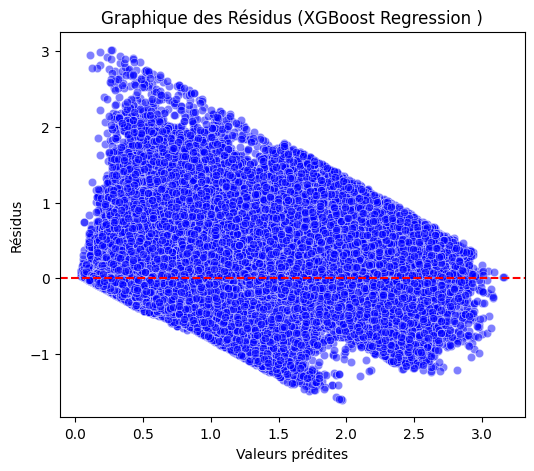

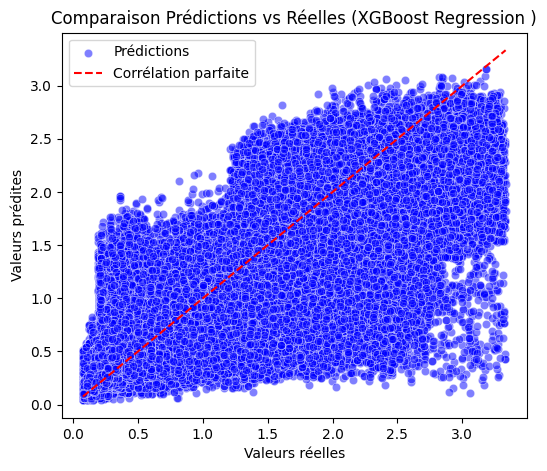

In [146]:
metrics_XGboost= evaluate_regression(y_test, y_pred_gb, model_name="XGBoost Regression ")

### Optimisation XGBoost avec RandomizedSearchCV

In [147]:

param_dist_xgb = {
    "n_estimators": [100, 200, 500],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 5, 10],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

random_search_xgb = RandomizedSearchCV(
    model, param_distributions=param_dist_xgb, 
    n_iter=15, cv=5, scoring='r2', 
    n_jobs=-1, verbose=2, random_state=42
)

random_search_xgb.fit(X_train, y_train)
y_pred_xgb = random_search_xgb.best_estimator_.predict(X_test)
print("XGBoost - Meilleurs paramètres :", random_search_xgb.best_params_)
print("R² XGBoost :", r2_score(y_test, y_pred_xgb))


Fitting 5 folds for each of 15 candidates, totalling 75 fits
XGBoost - Meilleurs paramètres : {'subsample': 0.6, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
R² XGBoost : 0.823729643678037


In [148]:

evaluate_regression_apres_optimisation(y_test,y_pred_xgb,"XGboost")


Évaluation du modèle : XGboost
MSE  : 0.0876
RMSE : 0.2960
MAE  : 0.1756
R²   : 0.8237


{'Modèle': 'XGboost',
 'MSE': 0.08762089662078568,
 'RMSE': 0.29600827120333256,
 'MAE': 0.1755735374077404,
 'R²': 0.823729643678037}

# Cross Validation

In [180]:
regression_scores = cross_val_score(lasso, X, y, cv=5, scoring='r2')
print("Score moyen :", regression_scores.mean())  # Score final

Score moyen : 0.6015492256948568


In [150]:
MLR_scores = cross_val_score(ML_regressor, X, y, cv=5, scoring='r2')
print("Score moyen :", MLR_scores.mean())  # Score final

Score moyen : 0.6351620848674868


In [151]:
tree_scores = cross_val_score(tree_regressor, X, y, cv=5, scoring='r2')
print("Score moyen :", tree_scores.mean())  # Score final

Score moyen : 0.7099949182928472


In [55]:
rf_scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
print("Score moyen :", rf_scores.mean())

Score moyen : 0.7159909833105106


In [152]:
bgr_scores = cross_val_score(gbr, X, y, cv=5, scoring='r2')
print("Score moyen :", bgr_scores.mean())

Score moyen : 0.7431830938336021


In [153]:
XGB_scores= cross_val_score(model, X, y, cv=5, scoring='r2')
print("Score moyen :", XGB_scores.mean())

Score moyen : 0.7559170484944503
